In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO CENÁRIO ---
np.random.seed(42)
n_samples = 2000
memory_L = 3  # Memória linear

# Sinal de entrada (ruído branco)
x = np.random.randn(n_samples)

# Planta Desconhecida: Sistema Volterra Quadrático Fixo
# d[k] = 0.8*x[k] - 0.5*x[k-2] + 0.4*x[k]^2 + 0.2*x[k]x[k-1] + ruído
d = np.zeros(n_samples)
for k in range(2, n_samples):
    d[k] = (0.8 * x[k] - 0.5 * x[k-2]) + \
           (0.4 * x[k]**2 + 0.2 * x[k] * x[k-1]) + \
           0.05 * np.random.randn()

# --- 2. EXECUÇÃO DO FILTRO VOLTERRA RLS ---
# n_coeffs = 3 + (3*4)/2 = 9 coeficientes
filt_rls = pdf.VolterraRLS(
    memory=memory_L,
    forgetting_factor=0.99, # Fator de esquecimento (lambda)
    delta=0.1               # Regularização inicial (P[0] = I/delta)
)

result = filt_rls.optimize(x, d, verbose=True, return_internal_states=True)

[VolterraRLS] Completed in 26.817 ms


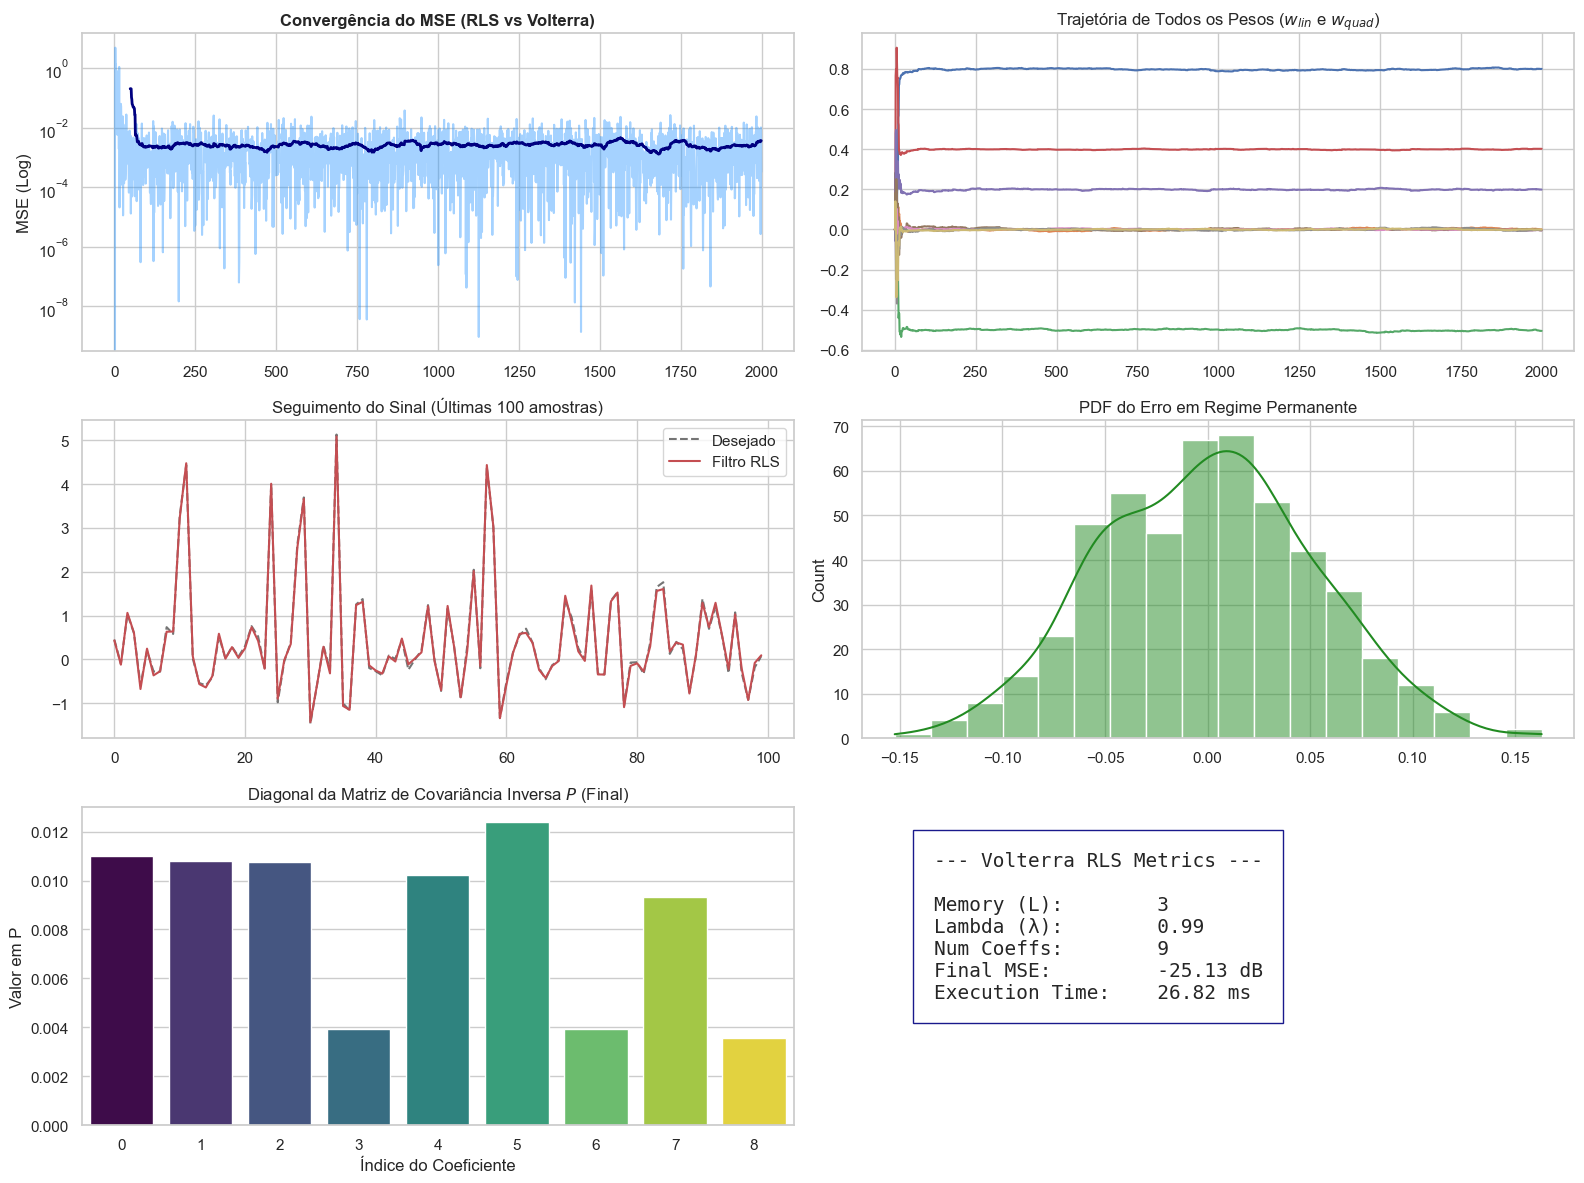

In [3]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_volterra_rls_dashboard(result, title):
    sns.set_theme(style="whitegrid")
    
    mse = result.mse()
    err = result.errors
    t = np.arange(len(mse))
    
    # Ajuste de dimensões para os coeficientes (N+1 -> N)
    coeffs = np.array(result.coefficients)[1:]
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='dodgerblue', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(50).mean(), color='navy', lw=2)
    ax1.set_title("Convergência do MSE (RLS vs Volterra)", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Evolução de Todos os Coeficientes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(t, coeffs)
    ax2.set_title("Trajetória de Todos os Pesos ($w_{lin}$ e $w_{quad}$)")

    # C. Comparação: Desejado vs Estimado (Zoom no final)
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(d[-100:], 'k--', label='Desejado', alpha=0.6)
    ax3.plot(result.outputs[-100:], 'r', label='Filtro RLS')
    ax3.set_title("Seguimento do Sinal (Últimas 100 amostras)")
    ax3.legend()

    # D. Histograma do Erro
    ax4 = fig.add_subplot(gs[1, 1])
    sns.histplot(err[-500:], kde=True, ax=ax4, color="forestgreen")
    ax4.set_title("PDF do Erro em Regime Permanente")

    # E. Visualização da Matriz P (Diagonal final)
    ax5 = fig.add_subplot(gs[2, 0])
    p_diag = np.diag(filt_rls.P)
    x_indices = list(range(len(p_diag)))
    
    # Correção do FutureWarning: definindo hue=x_indices
    sns.barplot(
        x=x_indices, 
        y=p_diag, 
        ax=ax5, 
        palette="viridis", 
        hue=x_indices, 
        legend=False
    )
    ax5.set_title("Diagonal da Matriz de Covariância Inversa $P$ (Final)")
    ax5.set_xlabel("Índice do Coeficiente")
    ax5.set_ylabel("Valor em P")

    # F. Resumo de Métricas
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Acesso seguro ao tempo de execução
    time_ms = getattr(result, 'runtime_ms', 0.0)
    
    stats_text = (
        f"--- Volterra RLS Metrics ---\n\n"
        f"Memory (L):        {result.extra.get('memory', 'N/A')}\n"
        f"Lambda (λ):        {result.extra.get('forgetting_factor', 'N/A')}\n"
        f"Num Coeffs:        {result.extra.get('n_coeffs', 'N/A')}\n"
        f"Final MSE:         {10*np.log10(np.mean(mse[-100:])):.2f} dB\n"
        f"Execution Time:    {time_ms:.2f} ms"
    )
    ax6.text(0.1, 0.4, stats_text, fontsize=14, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='navy', pad=15))

    plt.tight_layout()
    plt.show()

plot_volterra_rls_dashboard(result, "Volterra RLS Test")